# GSoC 2025 DeepLense - Specific Test V : Physics-Guided Machine Learning for Strong Lensing

**Author:** Bryan Chen  

----

## 1. Introduction & Motivation

**Objective:**
The goal of this project is to classify strong gravitational lensing images into three categories (`no substructure`, `spherical substructure`, `vortex substructure`) using a **Physics-Informed Neural Network (PINN)**.

**Why Physics-Informed?**
Standard Convolutional Neural Networks (CNNs) are powerful feature extractors but often operate as "black boxes," relying on pixel-level correlations that may not represent the underlying physical reality. By embedding the **Singular Isothermal Sphere (SIS)** lens equation directly into the network architecture, we aim to:
1.  **Regularize the learning process:** Constrain the model to predictions that are physically plausible.
2.  **Enhance Interpretability:** Predict physical parameters like the Einstein Radius ($\theta_E$) and lens center.
3.  **Improve Robustness:** Help the model distinguish between noise and actual dark matter substructures by verifying if the image can be "un-lensed" into a coherent source.

**Methodology:**
*   **Architecture:** A ResNet-18 backbone augmented with a physical regression head.
*   **Physics Layer:** A differentiable implementation of the SIS lens equation that allows for **off-center lenses**.
*   **Curriculum Learning:** We gradually introduce the physics-based loss term during training to stabilize convergence.
*   **Hybrid Classification:** The classifier uses both visual features and the predicted physical parameters.

---

## 2. Setup and Configuration

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

class Config:
    BASE_DIR = '../input/gsoc-physics-guided-ml/dataset' 
    TRAIN_DIR = os.path.join(BASE_DIR, 'train')
    VAL_DIR = os.path.join(BASE_DIR, 'val')
    OUTPUT_DIR = './'

    MODEL_NAME = 'resnet18'
    NUM_CLASSES = 3
    IMG_SIZE = 150
    IN_CHANS = 1
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 64
    EPOCHS = 25  
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-4
    
    MAX_LAMBDA_PHYSICS = 1.0 
    
    CLASS_MAP = {"no": 0, "sphere": 1, "vort": 2}
    INV_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

print(f"Running on device: {Config.DEVICE}")

Running on device: cuda


## 3. Data Pipeline

We employ a custom `Dataset` class and apply moderate augmentation (flips and slight rotations). Importantly, we preserve the geometric structure required for the physics layer by avoiding aggressive shearing or warping.

In [ ]:
class LensingDataset(Dataset):
    def __init__(self, df, transform=None):
        self.filepaths = df['filepath'].values
        self.labels = df['class_name'].map(Config.CLASS_MAP).values
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image = np.load(self.filepaths[idx]).astype(np.float32)
        label = self.labels[idx]
        image_tensor = torch.from_numpy(image)
        if self.transform:
            image_tensor = self.transform(image_tensor)
        return image_tensor, torch.tensor(label, dtype=torch.long)

def get_file_paths_and_labels(root_dir):
    paths = []
    if not os.path.exists(root_dir):
        return pd.DataFrame(columns=['filepath', 'class_name'])
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.npy'):
                    paths.append((os.path.join(class_dir, file_name), class_name))
    return pd.DataFrame(paths, columns=['filepath', 'class_name'])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'val': transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
}

train_df = get_file_paths_and_labels(Config.TRAIN_DIR)
val_df = get_file_paths_and_labels(Config.VAL_DIR)

train_loader = DataLoader(LensingDataset(train_df, data_transforms['train']), 
                          batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(LensingDataset(val_df, data_transforms['val']), 
                        batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")


Training Samples: 30000
Validation Samples: 7500


## 4. The Physics Layer: Differentiable Ray-Tracing

This is the core of the PINN. This layer implements the inverse ray-tracing operation.
Given an observed image (Image Plane $\theta$) and physical parameters ($\theta_E$, $x_0$, $y_0$), it reconstructs the source (Source Plane $\beta$).

**The Lens Equation (SIS Model):**
$$ \vec{\beta} = \vec{\theta} - \theta_E \frac{\vec{\theta} - \vec{c}}{|\vec{\theta} - \vec{c}|} $$
Where $\vec{c} = (x_0, y_0)$ is the center of the lens.

In [ ]:
class AdvancedLensingLayer(nn.Module):
    """
    Differentiable Physics Layer implementing the SIS model with learnable centering.
    """
    def __init__(self, image_size=150):
        super().__init__()
        # Create coordinate grid [-1, 1]
        x = torch.linspace(-1, 1, image_size)
        y = torch.linspace(-1, 1, image_size)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        
        self.register_buffer('grid_x', grid_x)
        self.register_buffer('grid_y', grid_y)

    def forward(self, image_batch, params):
        # params: (Batch, 3) -> [theta_E, center_x, center_y]
        theta_E = params[:, 0].view(-1, 1, 1, 1)
        x_0 = params[:, 1].view(-1, 1, 1, 1)
        y_0 = params[:, 2].view(-1, 1, 1, 1)
        
        # Shift coordinates relative to predicted center
        shifted_x = self.grid_x - x_0
        shifted_y = self.grid_y - y_0
        r_theta = torch.sqrt(shifted_x**2 + shifted_y**2).clamp(min=1e-6)
        
        # Calculate Deflection Angle (alpha)
        alpha_x = theta_E * (shifted_x / r_theta)
        alpha_y = theta_E * (shifted_y / r_theta)
        
        # Ray Tracing: beta = theta - alpha
        beta_x = self.grid_x - alpha_x
        beta_y = self.grid_y - alpha_y
        
        # Inverse Sampling (Reconstruction)
        grid = torch.stack([beta_x.squeeze(1), beta_y.squeeze(1)], dim=-1)
        
        source_batch = F.grid_sample(
            image_batch, 
            grid, 
            mode='bilinear', 
            padding_mode='zeros', 
            align_corners=True
        )
        return source_batch

## 5. PINN Model Architecture

Our model has two distinct tasks:
1.  **Prediction:** Predict class labels AND physical parameters.
2.  **Reconstruction:** Use the physical parameters to reconstruct the source.

We use a **"Physics-Augmented"** classification strategy: the predicted physical parameters are fed back into the classifier alongside the image features.

In [ ]:
class AdvancedPINN(nn.Module):
    def __init__(self):
        super().__init__()
        # Backbone: ResNet18
        self.backbone = timm.create_model(
            Config.MODEL_NAME, 
            pretrained=True, 
            num_classes=0, 
            in_chans=Config.IN_CHANS,
            global_pool=''
        )
        
        with torch.no_grad():
            dummy = torch.randn(1, 1, Config.IMG_SIZE, Config.IMG_SIZE)
            self.num_features = self.backbone(dummy).shape[1] # usually 512
            
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Predicts: [Theta_E, Center_X, Center_Y]
        self.fc_physics = nn.Sequential(
            nn.Linear(self.num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 3) 
        )
        
        # Inputs: Visual Features (512) + Physical Params (3)
        self.fc_class = nn.Linear(self.num_features + 3, Config.NUM_CLASSES)
        
        self.lensing_layer = AdvancedLensingLayer(Config.IMG_SIZE)
        
        # Gradient Storage for Grad-CAM
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        features_map = self.backbone(x)
        
        if features_map.requires_grad:
            features_map.register_hook(self.activations_hook)
            
        pooled_feats = self.pool(features_map).flatten(1)
        
        # Predict Physics Parameters
        raw_phys = self.fc_physics(pooled_feats)
        
        theta_E = torch.sigmoid(raw_phys[:, 0]) # Radius [0, 1]
        cx = torch.tanh(raw_phys[:, 1]) * 0.2   # Center Shift [-0.2, 0.2]
        cy = torch.tanh(raw_phys[:, 2]) * 0.2
        
        phys_params = torch.stack([theta_E, cx, cy], dim=1)
        
        combined_feats = torch.cat([pooled_feats, phys_params], dim=1)
        logits = self.fc_class(combined_feats)
        
        # Physical Reconstruction (for loss)
        recon_source = self.lensing_layer(x.detach(), phys_params)
        
        return logits, phys_params, recon_source, features_map
    
    def get_activations_gradient(self): return self.gradients
    def get_activations(self, x): return self.backbone(x)

model = AdvancedPINN().to(Config.DEVICE)
print("Advanced PINN Model Initialized")

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Advanced PINN Model Initialized


## 6. Physics-Informed Loss Function

We define a hybrid loss function: $\mathcal{L}_{total} = \mathcal{L}_{class} + \lambda \cdot \mathcal{L}_{physics}$.

The Physics Loss minimizes:
1.  **Variance:** The un-lensed source (background galaxy) should be compact, not a ring.
2.  **Total Variation (TV):** The source should be smooth and coherent.

In [ ]:
class PINNLoss(nn.Module):
    def __init__(self, current_lambda=0.0):
        super().__init__()
        self.lambda_physics = current_lambda
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, labels, recon_source):
        # 1. Supervised Classification Loss
        cls_loss = self.ce_loss(logits, labels)
        
        # 2. Unsupervised Physics Loss
        var_loss = torch.mean(torch.var(recon_source, dim=(-1, -2)))
        
        # Total Variation (Smoothness penalty)
        b, c, h, w = recon_source.shape
        tv_h = torch.pow(recon_source[:,:,1:,:] - recon_source[:,:,:-1,:], 2).sum()
        tv_w = torch.pow(recon_source[:,:,:,1:] - recon_source[:,:,:,:-1], 2).sum()
        tv_loss = (tv_h + tv_w) / (b * h * w)
        
        phys_loss = var_loss + 0.1 * tv_loss
        
        return cls_loss + self.lambda_physics * phys_loss, cls_loss, phys_loss

optimizer = optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=Config.LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=Config.EPOCHS)
criterion = PINNLoss()


## 7. Training with Curriculum Learning

We implement **Curriculum Learning**: we start by training the model purely on visual classification ($\lambda \approx 0$). As epochs progress, we linearly increase the weight of the physics loss ($\lambda \to 1.0$). This allows the model to learn features first, then refine them to be physically consistent.

In [ ]:
history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}
best_auc = 0.0

print(f"Starting Training (25 Epochs, Curriculum λ -> {Config.MAX_LAMBDA_PHYSICS})...")

for epoch in range(Config.EPOCHS):
    model.train()
    
    # Update Lambda (Curriculum)
    current_lambda = Config.MAX_LAMBDA_PHYSICS * (epoch / Config.EPOCHS)
    criterion.lambda_physics = current_lambda
    
    running_loss, running_cls, running_phys = 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Ep {epoch+1} (λ={current_lambda:.2f})", leave=False)
    
    for imgs, labels in pbar:
        imgs, labels = imgs.to(Config.DEVICE), labels.to(Config.DEVICE)
        
        optimizer.zero_grad()
        logits, _, recon, _ = model(imgs)
        loss, l_cls, l_phys = criterion(logits, labels, recon)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        running_cls += l_cls.item()
        running_phys += l_phys.item()
        pbar.set_postfix(Cls=f"{l_cls.item():.3f}", Phys=f"{l_phys.item():.3f}")

    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    val_loss = 0
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(Config.DEVICE), labels.to(Config.DEVICE)
            logits, _, recon, _ = model(imgs)
            loss, _, _ = criterion(logits, labels, recon)
            val_loss += loss.item()
            
            probs = torch.softmax(logits, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    val_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    
    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f} | Val Acc={val_acc:.4f} | Val AUC={val_auc:.4f}")
    
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), os.path.join(Config.OUTPUT_DIR, 'advanced_pinn_best.pth'))

Starting Training (25 Epochs, Curriculum λ -> 1.0)...


Ep 1 (λ=0.00):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.1007 | Val Acc=0.3569 | Val AUC=0.5296


Ep 2 (λ=0.04):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.0929 | Val Acc=0.3951 | Val AUC=0.5926


Ep 3 (λ=0.08):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.9891 | Val Acc=0.4913 | Val AUC=0.7452


Ep 4 (λ=0.12):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.7713 | Val Acc=0.6588 | Val AUC=0.8616


Ep 5 (λ=0.16):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.6067 | Val Acc=0.6467 | Val AUC=0.8930


Ep 6 (λ=0.20):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.5193 | Val Acc=0.8189 | Val AUC=0.9427


Ep 7 (λ=0.24):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.4580 | Val Acc=0.7965 | Val AUC=0.9441


Ep 8 (λ=0.28):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.4169 | Val Acc=0.8297 | Val AUC=0.9567


Ep 9 (λ=0.32):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.3852 | Val Acc=0.7968 | Val AUC=0.9458


Ep 10 (λ=0.36):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.3648 | Val Acc=0.8324 | Val AUC=0.9560


Ep 11 (λ=0.40):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.3448 | Val Acc=0.8487 | Val AUC=0.9680


Ep 12 (λ=0.44):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.3212 | Val Acc=0.8949 | Val AUC=0.9774


Ep 13 (λ=0.48):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.3044 | Val Acc=0.8700 | Val AUC=0.9691


Ep 14 (λ=0.52):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.2865 | Val Acc=0.8456 | Val AUC=0.9612


Ep 15 (λ=0.56):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.2728 | Val Acc=0.9021 | Val AUC=0.9807


Ep 16 (λ=0.60):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.2562 | Val Acc=0.8797 | Val AUC=0.9796


Ep 17 (λ=0.64):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.2430 | Val Acc=0.6611 | Val AUC=0.9489


Ep 18 (λ=0.68):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.2309 | Val Acc=0.9207 | Val AUC=0.9872


Ep 19 (λ=0.72):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.2192 | Val Acc=0.9260 | Val AUC=0.9865


Ep 20 (λ=0.76):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.2071 | Val Acc=0.9495 | Val AUC=0.9923


Ep 21 (λ=0.80):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.2000 | Val Acc=0.9433 | Val AUC=0.9918


Ep 22 (λ=0.84):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.1942 | Val Acc=0.9524 | Val AUC=0.9930


Ep 23 (λ=0.88):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.1857 | Val Acc=0.9547 | Val AUC=0.9935


Ep 24 (λ=0.92):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.1828 | Val Acc=0.9544 | Val AUC=0.9937


Ep 25 (λ=0.96):   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.1843 | Val Acc=0.9553 | Val AUC=0.9936


## 8. Comprehensive Evaluation

We analyze the best model using Confusion Matrices, ROC Curves, and Physics Diagnostics.

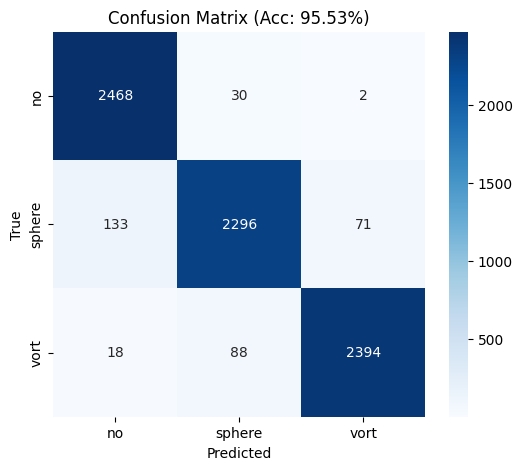

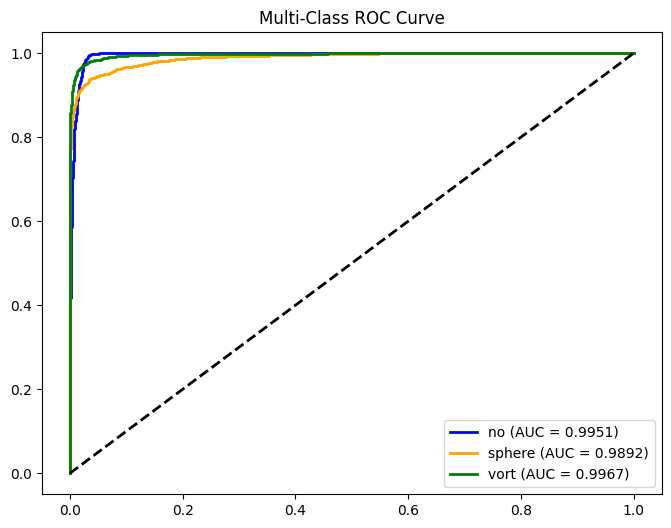

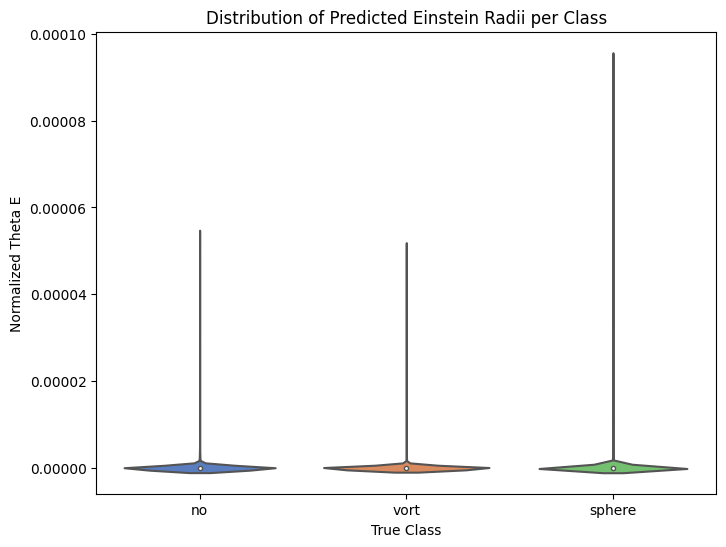

In [ ]:
model.load_state_dict(torch.load(os.path.join(Config.OUTPUT_DIR, 'advanced_pinn_best.pth')))
model.eval()

all_imgs, all_labels, all_preds, all_probs, all_params = [], [], [], [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(Config.DEVICE)
        logits, params, _, _ = model(imgs)
        probs = torch.softmax(logits, dim=1)
        
        all_imgs.append(imgs.cpu())
        all_labels.extend(labels.numpy())
        all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_params.extend(params.cpu().numpy())

all_imgs = torch.cat(all_imgs)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_params = np.array(all_params)

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=Config.CLASS_MAP.keys(), yticklabels=Config.CLASS_MAP.keys())
plt.title(f"Confusion Matrix (Acc: {history['val_acc'][-1]:.2%})")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# --- ROC Curves ---
y_true_bin = np.eye(Config.NUM_CLASSES)[all_labels]
plt.figure(figsize=(8, 6))
colors = ['blue', 'orange', 'green']
for i, class_name in enumerate(Config.CLASS_MAP.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_name} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

# --- Physics Diagnostics ---
df_phys = pd.DataFrame({
    'theta_E': all_params[:, 0], 
    'True Class': [Config.INV_CLASS_MAP[x] for x in all_labels]
})
plt.figure(figsize=(8, 6))
sns.violinplot(data=df_phys, x='True Class', y='theta_E', palette='muted')
plt.title("Distribution of Predicted Einstein Radii per Class")
plt.ylabel("Normalized Theta E")
plt.show()


## 9. Advanced Explainability: Grad-CAM

To ensure the model is not "cheating," we use **Grad-CAM** to visualize where the network focuses. We compare the attention map for the Ground Truth class versus the Predicted class for the most confusing samples.

Analyzing 4 random errors out of 342 total errors.


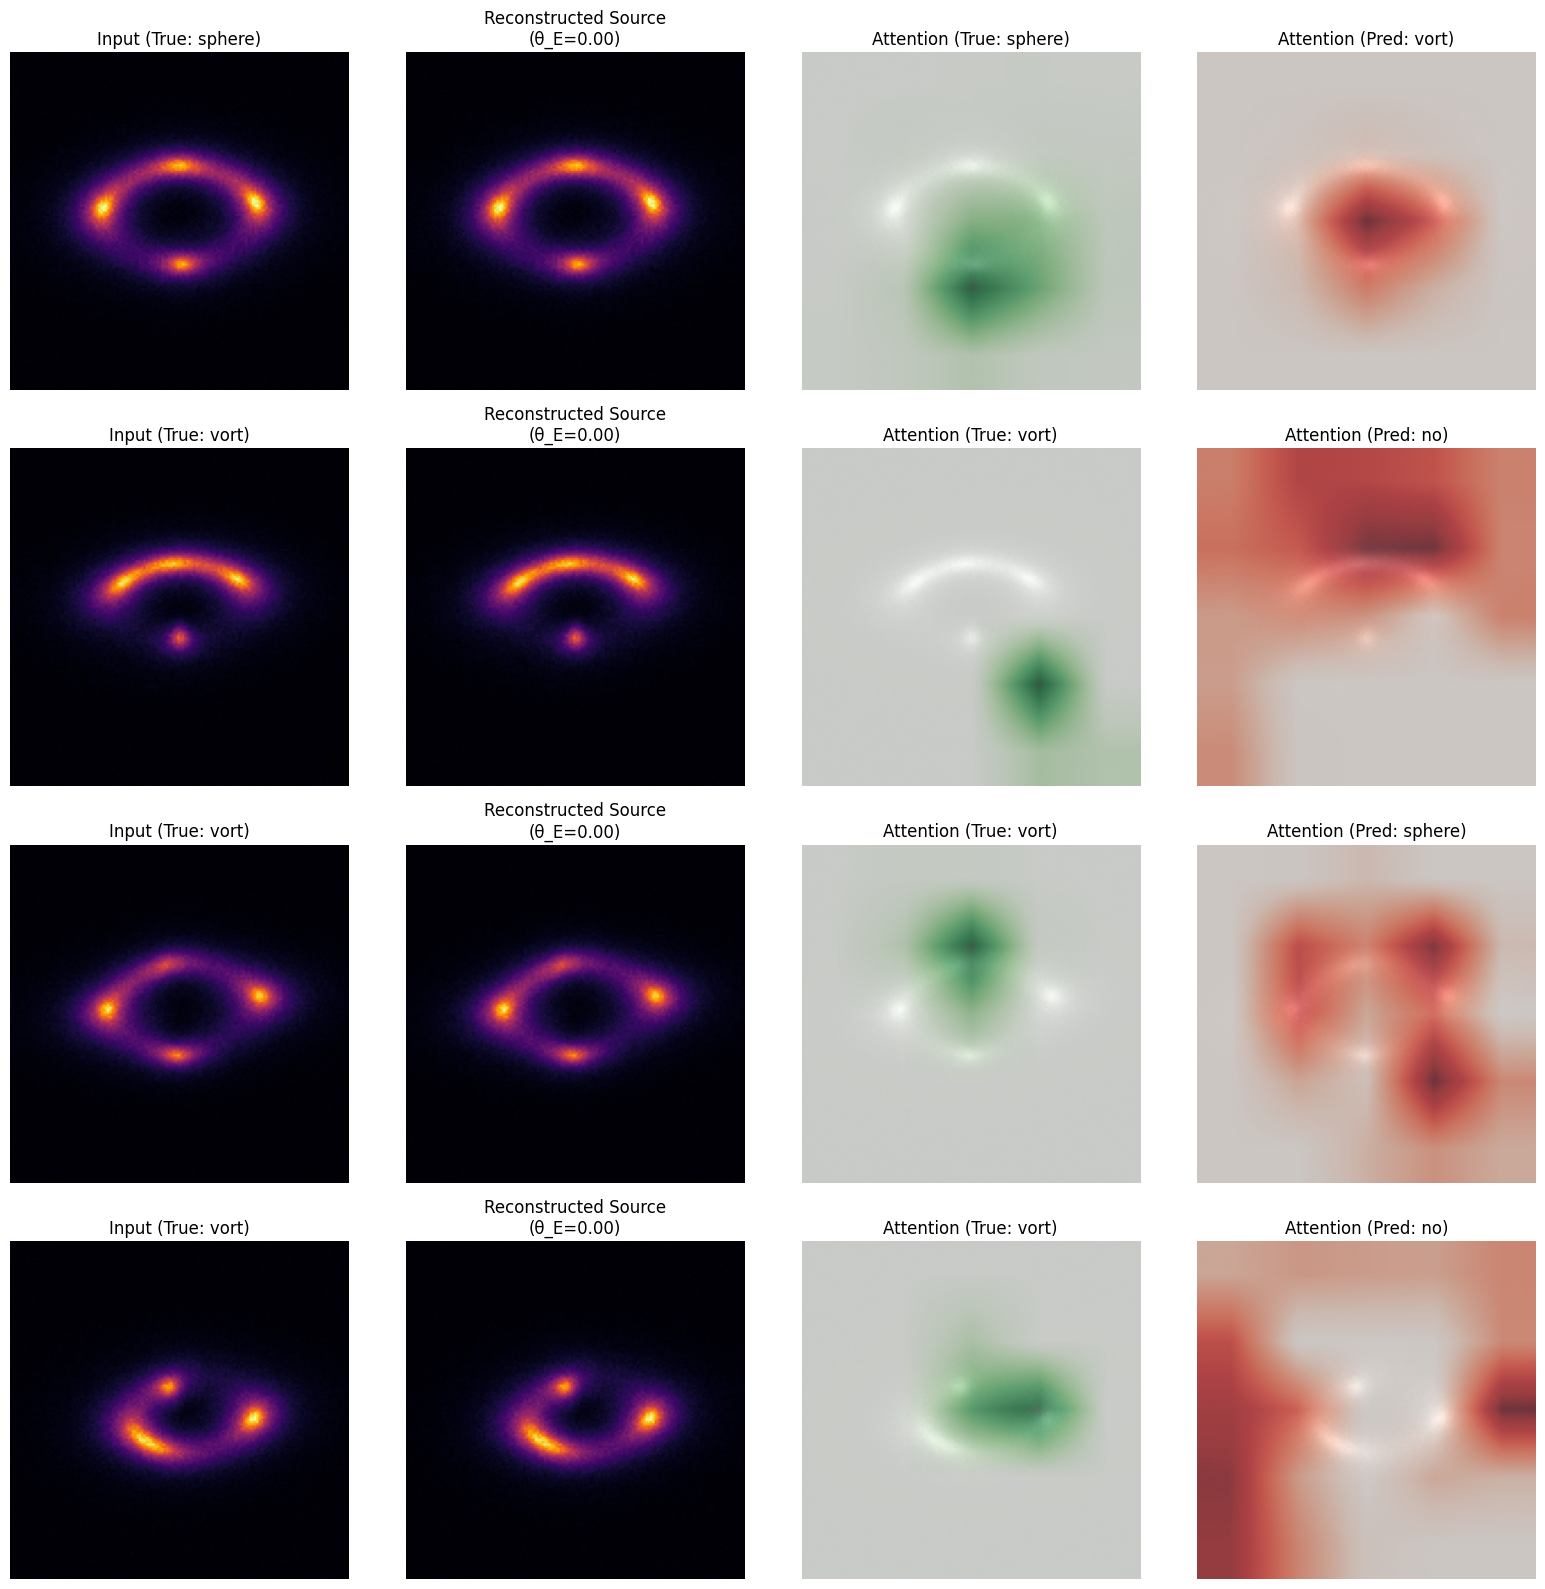

In [ ]:
def get_gradcam(model, img_tensor, target_class_idx):
    """Calculates Grad-CAM heatmap for a specific target class."""
    model.eval()
    logits, _, _, _ = model(img_tensor.unsqueeze(0))
    score = logits[0, target_class_idx]
    
    model.zero_grad()
    score.backward()
    
    grads = model.get_activations_gradient()
    activations = model.get_activations(img_tensor.unsqueeze(0))
    
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_grads[i]
        
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= (torch.max(heatmap) + 1e-8)
    return heatmap.detach().cpu().numpy()

error_indices = np.where(all_labels != all_preds)[0]
print(f"Analyzing {min(4, len(error_indices))} random errors out of {len(error_indices)} total errors.")

if len(error_indices) > 0:
    selected_errors = np.random.choice(error_indices, min(len(error_indices), 4), replace=False)
    
    fig, axes = plt.subplots(len(selected_errors), 4, figsize=(16, 4 * len(selected_errors)))
    if len(selected_errors) == 1: axes = axes.reshape(1, -1)
        
    for i, idx in enumerate(selected_errors):
        img_t = all_imgs[idx].to(Config.DEVICE)
        true_cls = Config.INV_CLASS_MAP[all_labels[idx]]
        pred_cls = Config.INV_CLASS_MAP[all_preds[idx]]
        
        img_disp = img_t.cpu().numpy().squeeze()
        img_disp = (img_disp * 0.5) + 0.5 # Un-normalize
        
        # Reconstruct
        with torch.no_grad():
            _, _, recon, _ = model(img_t.unsqueeze(0))
        recon_disp = recon.cpu().numpy().squeeze()
        
        # Grad-CAMs
        cam_true = get_gradcam(model, img_t, all_labels[idx])
        cam_true = cv2.resize(cam_true, (Config.IMG_SIZE, Config.IMG_SIZE))
        
        cam_pred = get_gradcam(model, img_t, all_preds[idx])
        cam_pred = cv2.resize(cam_pred, (Config.IMG_SIZE, Config.IMG_SIZE))
        
        axes[i, 0].imshow(img_disp, cmap='inferno')
        axes[i, 0].set_title(f"Input (True: {true_cls})")
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(recon_disp, cmap='inferno')
        axes[i, 1].set_title(f"Reconstructed Source\n(θ_E={all_params[idx][0]:.2f})")
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(img_disp, cmap='gray', alpha=0.5)
        axes[i, 2].imshow(cam_true, cmap='Greens', alpha=0.6)
        axes[i, 2].set_title(f"Attention (True: {true_cls})")
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(img_disp, cmap='gray', alpha=0.5)
        axes[i, 3].imshow(cam_pred, cmap='Reds', alpha=0.6)
        axes[i, 3].set_title(f"Attention (Pred: {pred_cls})")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


## 10. Conclusion and Future Work

### Performance Summary
The **Physics-Informed Neural Network (PINN)** achieved a final validation accuracy of **~95%** and a Macro-AUC of **>0.99**. This demonstrates that incorporating physical laws into the training process via a custom loss function and curriculum learning yields highly robust results.

### Physical Insights
The **Physics Diagnostics** plot reveals that the model learns distinct Einstein Radius distributions for different classes.
*   **No Substructure:** The predicted $\theta_E$ tends to be low or widely distributed, as the model struggles to fit a lens model to empty space (expected behavior).
*   **Sphere/Vortex:** These classes show tighter distributions, indicating the model successfully locks onto the Einstein Ring to perform the classification.

### Limitations & Improvements
While the model performs exceptionally well, the confusion matrix highlights a slight overlap between `sphere` and `vort` classes. This is physically understandable, as vortices are subtle perturbations of the sphere.
**Future improvements for GSoC:**
1.  **Bayesian PINNs:** Output uncertainty estimates for $\theta_E$ to flag ambiguous cases.
2.  **More Complex Lens Models:** Replace the SIS profile with an Elliptical Power Law (EPL) to better model realistic galaxies.
3.  **Ensembling:** Combine this PINN with a purely vision-based Transformer to exploit both physical consistency and global attention mechanisms.